In [4]:
%matplotlib widget

import sys
import os
import logging
import matplotlib
import mplcursors
import matplotlib.pyplot as plt 
import numpy as np
from astropy.io.votable import parse
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

from pyvo.dal.scs import SCSService

from pyvo.mivot.viewer.mivot_viewer import MivotViewer
from pyvo.mivot.features.sky_coord_builder import SkyCoordBuilder
from pyvo.mivot.utils.dict_utils import DictUtils
from pyvo.mivot.utils.xml_utils import XmlUtils

from pyvo.utils import activate_features
from pyvo.dal.scs import SCSService

activate_features("MIVOT")


In [52]:

SERVER = "https://simbad.cds.unistra.fr/cone?"
VERB = 1
RA = 269.452076* u.degree
DEC = 4.6933649* u.degree
SR = 0.1* u.degree
MAXREC = 100


In [53]:
matplotlib.pyplot.close("all")
scs_srv = SCSService(SERVER)

query_result = scs_srv.search(
    pos=SkyCoord(ra=RA, dec=DEC, frame='icrs'), radius=SR,
    verbosity=VERB,
    RESPONSEFORMAT="mivot", MAXREC=MAXREC)
# The MIVOt viewer generates the model view of the data
m_viewer = MivotViewer(query_result, resolve_ref=True)
# Get the first instance mapped in the MIVOt <TEMPLATES>
#XmlUtils.pretty_print(m_viewer._mapping_block)

dates =[]
ras = []
decs = []
now_ras = []
now_decs = []
mango_label = None

mivot_instance = m_viewer.dm_instance
if mivot_instance.dmtype == "mango:MangoObject":
    mango_properties = mivot_instance.propertyDock
    for mango_property in mango_properties:
        if mango_property == "mango:Label":
            mango_label = mango_property
    # iterate over the table rows
    while m_viewer.next_row_view():

        scb = SkyCoordBuilder(mivot_instance.to_dict())
        sky_coord = scb.build_sky_coord()
            
        dates.append(f" {mivot_instance.identifier.value}\n ({str(sky_coord.obstime).replace('J', '')})")
        ras.append(sky_coord.ra.deg)
        decs.append(sky_coord.dec.deg)

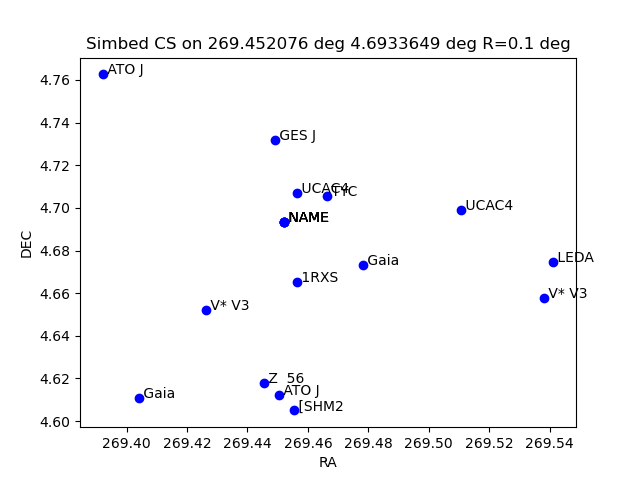

In [54]:
_, ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
plt.title(f"Simbed CS on {RA} {DEC} R={SR}")
plt.xlabel("RA")
plt.ylabel("DEC")
scatter = ax.scatter(ras, decs, color="blue")

for i, txt in enumerate(dates):
    ax.annotate(txt[:6], (ras[i], decs[i]))
    
# Add tooltips using mplcursors
mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(dates[sel.index]))

plt.show()


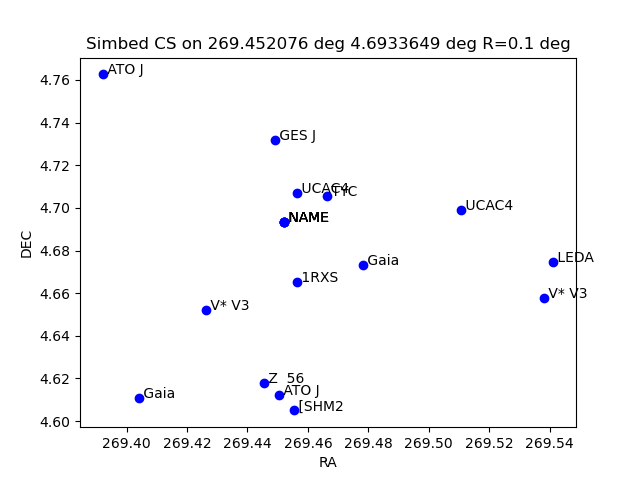

In [63]:
matplotlib.pyplot.close("all")
VERB = 2
query_result = scs_srv.search(
    pos=SkyCoord(ra=RA, dec=DEC, frame='icrs'), radius=SR,
    verbosity=VERB,
    RESPONSEFORMAT="mivot", MAXREC=MAXREC)
# The MIVOt viewer generates the model view of the data
m_viewer = MivotViewer(query_result, resolve_ref=True)
# Get the first instance mapped in the MIVOt <TEMPLATES>
# XmlUtils.pretty_print(m_viewer._mapping_block)

dates =[]
ras = []
decs = []
now_ras = []
now_decs = []
mango_labels = []

mivot_instance = m_viewer.dm_instance
if mivot_instance.dmtype == "mango:MangoObject":
    mango_properties = mivot_instance.propertyDock
    for mango_property in mango_properties:
        if mango_property.dmtype == "mango:label" or mango_property.dmtype == "mango:Label":    
            mango_labels.append(mango_property)
    # iterate over the table rows
    while m_viewer.next_row_view():

        scb = SkyCoordBuilder(mivot_instance.to_dict())
        sky_coord = scb.build_sky_coord()
        lm = ""
        for mango_label in mango_labels:
            lm += mango_label.text.value + " - "
        dates.append(f" {mivot_instance.identifier.value}\n {lm} ({str(sky_coord.obstime).replace('J', '')})")
        ras.append(sky_coord.ra.deg)
        decs.append(sky_coord.dec.deg)

_, ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
plt.title(f"Simbed CS on {RA} {DEC} R={SR}")
plt.xlabel("RA")
plt.ylabel("DEC")
scatter = ax.scatter(ras, decs, color="blue")

for i, txt in enumerate(dates):
    ax.annotate(txt[:6], (ras[i], decs[i]))
    
# Add tooltips using mplcursors
mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(dates[sel.index]))

plt.show()
        

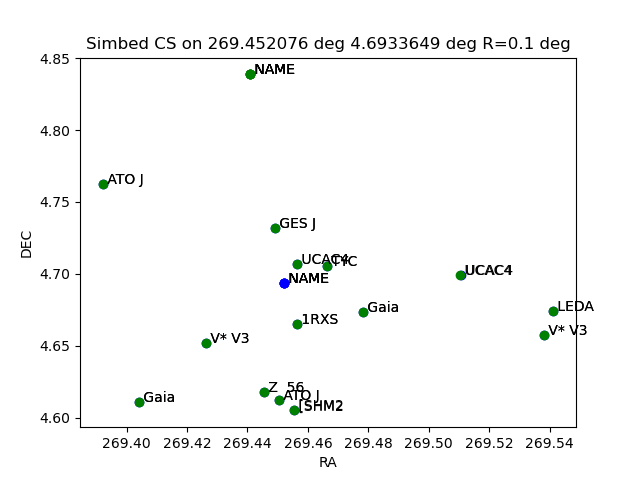

In [84]:
matplotlib.pyplot.close("all")
VERB = 2
query_result = scs_srv.search(
    pos=SkyCoord(ra=RA, dec=DEC, frame='icrs'), radius=SR,
    verbosity=VERB,
    RESPONSEFORMAT="mivot", MAXREC=MAXREC)
# The MIVOt viewer generates the model view of the data
m_viewer = MivotViewer(query_result, resolve_ref=True)
# Get the first instance mapped in the MIVOt <TEMPLATES>
# XmlUtils.pretty_print(m_viewer._mapping_block)

dates =[]
future_dates =[]
ras = []
decs = []
now_ras = []
now_decs = []
mango_labels = []

mivot_instance = m_viewer.dm_instance
if mivot_instance.dmtype == "mango:MangoObject":
    mango_properties = mivot_instance.propertyDock
    for mango_property in mango_properties:
        if mango_property.dmtype == "mango:label" or mango_property.dmtype == "mango:Label":    
            mango_labels.append(mango_property)
    # iterate over the table rows
    while m_viewer.next_row_view():

        scb = SkyCoordBuilder(mivot_instance.to_dict())
        sky_coord = scb.build_sky_coord()
        lm = ""
        for mango_label in mango_labels:
            lm += mango_label.text.value + " - "
        dates.append(f" {mivot_instance.identifier.value}\n epoch: 2000 \n {lm} \n {str(sky_coord)}")
        ras.append(sky_coord.ra.deg)
        decs.append(sky_coord.dec.deg)
        try:
            sky_coord_future = sky_coord.apply_space_motion(new_obstime=Time('J2050.5'))
            now_ras.append(sky_coord_future.ra.deg)
            now_decs.append(sky_coord_future.dec.deg)
            future_dates.append(f" {mivot_instance.identifier.value}\n epoch: 2025.5 \n {lm} \n {str(sky_coord_future)}")
        except Exception:
            now_ras.append(sky_coord.ra.deg)
            now_decs.append(sky_coord.dec.deg)
            future_dates.append(f" {mivot_instance.identifier.value}\n epoch: 2025.5 \n {lm} \n {str(sky_coord)}")
            


_, ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
plt.title(f"Simbed CS on {RA} {DEC} R={SR}")
plt.xlabel("RA")
plt.ylabel("DEC")
scatter = ax.scatter(ras, decs, color="blue")
scatter_future = ax.scatter(now_ras, now_decs, color="green")

for i, txt in enumerate(dates):
    ax.annotate(txt[:6], (ras[i], decs[i]))
    ax.annotate(txt[:6], (now_ras[i], now_decs[i]))
    
# Add tooltips using mplcursors
#mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(dates[sel.index]))
cursor = mplcursors.cursor(scatter, hover=True)

@cursor.connect("add")
def on_add(sel):
    sel.annotation.set_text(dates[sel.index])
    sel.annotation.get_bbox_patch().set(fc="yellow", alpha=1)  # style optionnel
    sel.annotation.set_ha("left") 
    
cursor = mplcursors.cursor(scatter_future, hover=True)

@cursor.connect("add")
def on_add(sel):
    sel.annotation.set_text(future_dates[sel.index])
    sel.annotation.get_bbox_patch().set(fc="yellow", alpha=1)  # style optionnel
    sel.annotation.set_ha("left") 

plt.show()
        